In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")

# Using the Custom Explainer in the xai-comparison package

In some cases, the default explainers provided by the XAI Comparison package (like SHAP, LIME, and Permutation Importance) might not fully meet the specific requirements of your project. You might need to create a custom explainer to incorporate domain-specific knowledge, custom metrics, or proprietary methods that are not available in the default explainers. This notebook demonstrates how to create and use a custom explainer in the XAI Comparison package, using a `RandomForestClassifier` on the German credit dataset.

## Step 1: Define the model, load the dataset, and set the mode

Next, we define the model we will use for the demonstration, load the German credit dataset, and set the mode to classification.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from xai_compare.datasets import german_credit
from xai_compare.config import MODE

model = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42)

# Load the dataset
X, y = german_credit()
print("Data loaded successfully!")

# Set the mode
mode = MODE.CLASSIFICATION

Data loaded successfully!


## Step 2: Create a Custom Explainer

First, let’s create a custom explainer class that inherits from Explainer. This custom explainer will demonstrate how to implement a new explainer that generates random local explanations and computes the mean of these local explanations for a global explanation.

In [3]:
import pandas as pd
import numpy as np

# Local application imports
from xai_compare.abstract.explainer import Explainer
from xai_compare.config import MODE


class CustomExplainer(Explainer):
    """
    A custom explainer that demonstrates how to implement a new explainer
    inheriting from the abstract Explainer base class.
    """

    def __init__(self, model, X_train, y_train, y_pred=None, mode=MODE.CLASSIFICATION):
        super().__init__(model, X_train, y_train, y_pred, mode)

    def explain_global(self, X_data: pd.DataFrame) -> pd.DataFrame:
        """
        Generates a global explanation for the model predictions.
        This custom explainer returns the mean of the local explanations.
        """
        local_exps = self.explain_local(X_data)
        global_exp = np.mean(local_exps, axis=0)
        return pd.DataFrame(global_exp, index=X_data.columns, columns=['Custom Explainer Value'])

    def explain_local(self, X_data: pd.DataFrame) -> pd.DataFrame:
        """
        Generates a local explanation for the model predictions for individual samples.
        For demonstration, this custom explainer returns a DataFrame with random values.
        """

        normalized_data = (X_data - X_data.min()) / (X_data.max() - X_data.min())
        explanation = pd.DataFrame(np.random.rand(*normalized_data.shape) * normalized_data.values, columns=X_data.columns)
        return explanation

## Step 3: Configure Parameters with the Custom Explainer

In this step, we define the parameters for the `ComparisonFactory`. These parameters include the model, dataset, target, and the custom explainer.

In [5]:
params = {
    'model': model,
    'data': X,
    'target': y,
    'verbose': False,
    'mode': mode,
    'default_explainers': ['shap'],  # Optionally, specify default explainers or leave empty
    'custom_explainer': CustomExplainer  # Pass the custom explainer
}

## Step 4: Initialize the ComparisonFactory

The `ComparisonFactory` is responsible for creating comparison objects based on the given explainers and other parameters.

In [6]:
from xai_compare.factories.factory import ComparisonFactory

# Initialize the ComparisonFactory
comparison_factory = ComparisonFactory(**params)

## Step 5: Create and Apply Comparisons

Loop through the comparison techniques and apply them to the model and data.

Applying feature_selection...


Explainers: 100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


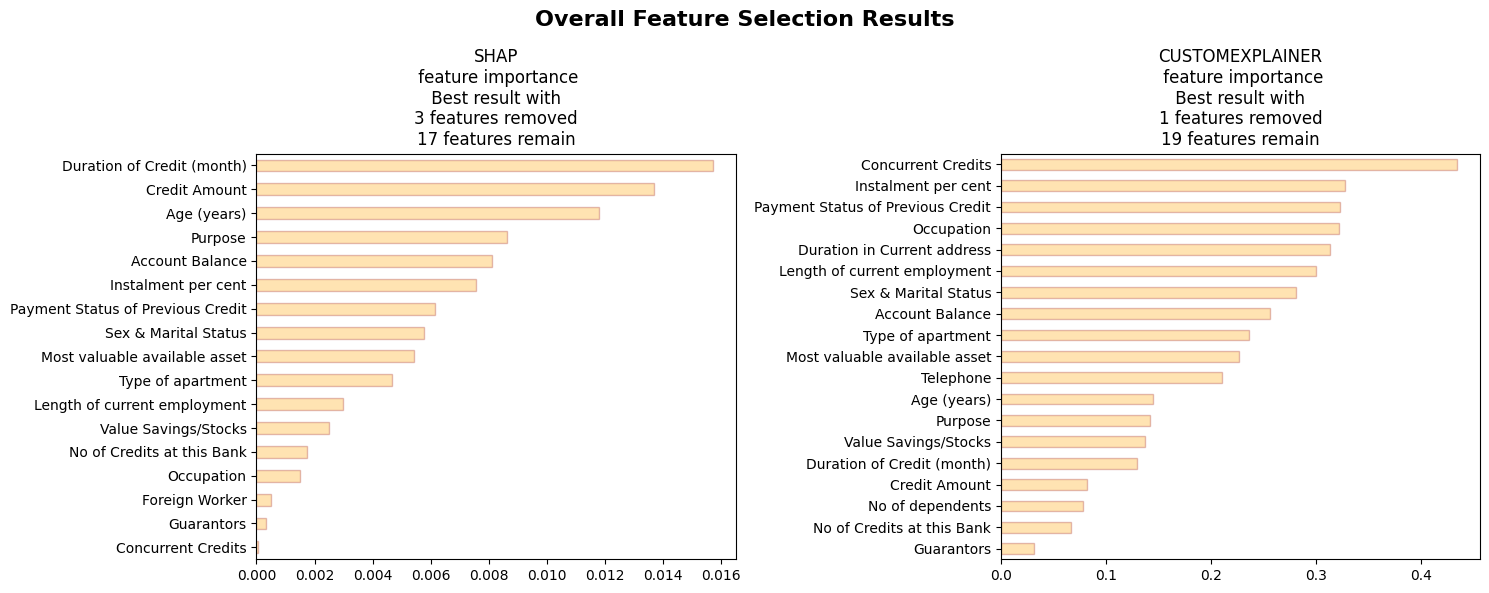

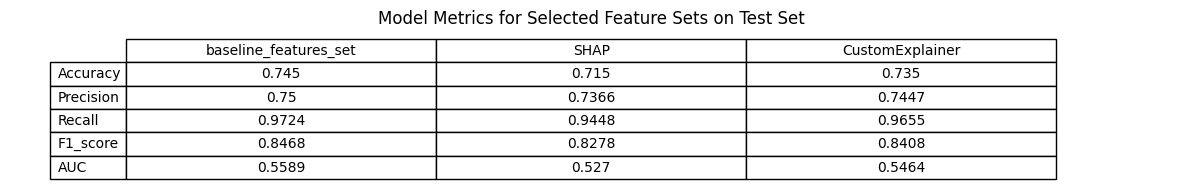

Applying consistency...


Processing folds: 100%|██████████| 5/5 [00:00<00:00,  9.63it/s]


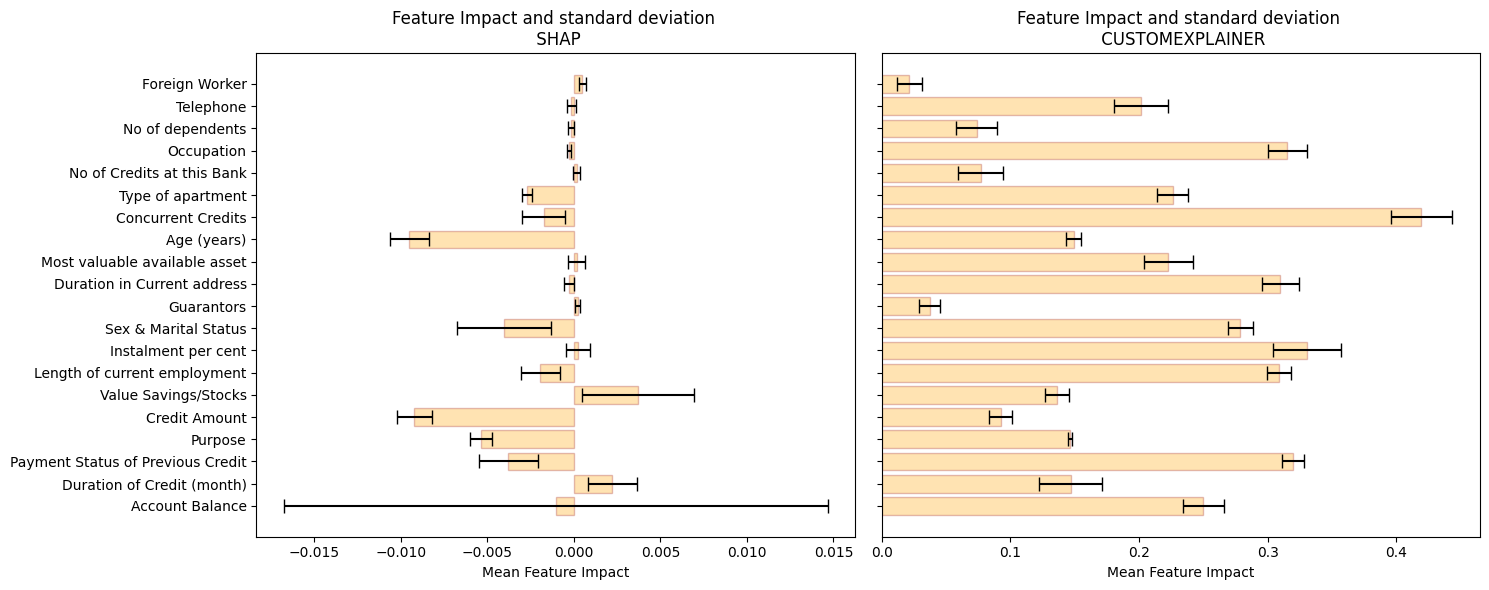

                  min_std   max_std  mean_std  median_std
SHAP             0.000107  0.015712  0.001641    0.000667
CustomExplainer  0.001423  0.026368  0.013904    0.013241


In [7]:
from xai_compare.config import COMPARISON_TECHNIQUES

for technique in COMPARISON_TECHNIQUES:
    print(f"Applying {technique}...")
    comparison = comparison_factory.create(technique)
    comparison.apply()
    comparison.display()


## Conclusion

This notebook provides guidance on how to create and use a custom explainer. To do this, you define a class that inherits from the `Explainer` abstract base class and implement the `explain_global` and `explain_local` methods. Once the custom explainer class is defined, you can instantiate it and pass it to the ComparisonFactory as part of the parameters. This allows you to extend the functionality of the xai-comparison package and adapt it to your specific needs, providing a flexible and powerful way to interpret model predictions.